In [14]:
import os

import mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib
matplotlib.use('TkAgg') # Or 'Qt5Agg' if you have PyQt installed
import matplotlib.pyplot as plt

In [23]:
DATA_PATH = r"C:\Users\azeem\PycharmProjects\ImageProcessingSemesterProject\Dataset\Final_Split_Dataset\Filtered_Train"
TARGET_CLASS_NAME = 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'

IMG_SIZE = 64
BATCH_SIZE = 32
Z_DIM = 100
LR = 0.0002
EPOCHS = 400

transform = transforms.Compose([
    transforms.Resize((80, 80)),

    transforms.RandomCrop((IMG_SIZE, IMG_SIZE)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.05),

    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)
target_idx = full_dataset.class_to_idx[TARGET_CLASS_NAME]
minority_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == target_idx]
minority_dataset = torch.utils.data.Subset(full_dataset, minority_indices)

dataloader = DataLoader(minority_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
print(f"✅ Loaded {len(minority_dataset)} images.")

✅ Loaded 1124 images.


In [24]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 100 -> 512
            nn.ConvTranspose2d(Z_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 512 -> 256
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 256 -> 128
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 128 -> 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64 -> 3 (Image)
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 3 -> 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 -> 128
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 -> 256
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 -> 512
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 -> 1 (Probability)
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(DEVICE)
netD = Discriminator().to(DEVICE)

In [27]:
summary(Generator(), input_size=(BATCH_SIZE, Z_DIM, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 64, 64]           --
├─Sequential: 1-1                        [32, 3, 64, 64]           --
│    └─ConvTranspose2d: 2-1              [32, 512, 4, 4]           819,200
│    └─BatchNorm2d: 2-2                  [32, 512, 4, 4]           1,024
│    └─ReLU: 2-3                         [32, 512, 4, 4]           --
│    └─ConvTranspose2d: 2-4              [32, 256, 8, 8]           2,097,152
│    └─BatchNorm2d: 2-5                  [32, 256, 8, 8]           512
│    └─ReLU: 2-6                         [32, 256, 8, 8]           --
│    └─ConvTranspose2d: 2-7              [32, 128, 16, 16]         524,288
│    └─BatchNorm2d: 2-8                  [32, 128, 16, 16]         256
│    └─ReLU: 2-9                         [32, 128, 16, 16]         --
│    └─ConvTranspose2d: 2-10             [32, 64, 32, 32]          131,072
│    └─BatchNorm2d: 2-11                 [32, 64, 32, 32] 

In [28]:
summary(Discriminator(), input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1, 1, 1]             --
├─Sequential: 1-1                        [32, 1, 1, 1]             --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          3,072
│    └─LeakyReLU: 2-2                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [32, 128, 16, 16]         131,072
│    └─BatchNorm2d: 2-4                  [32, 128, 16, 16]         256
│    └─LeakyReLU: 2-5                    [32, 128, 16, 16]         --
│    └─Conv2d: 2-6                       [32, 256, 8, 8]           524,288
│    └─BatchNorm2d: 2-7                  [32, 256, 8, 8]           512
│    └─LeakyReLU: 2-8                    [32, 256, 8, 8]           --
│    └─Conv2d: 2-9                       [32, 512, 4, 4]           2,097,152
│    └─BatchNorm2d: 2-10                 [32, 512, 4, 4]           1,024
│    └─LeakyReLU: 2-11                   [32, 512, 4, 4]    

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [30]:
netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)

In [12]:
import pandas as pd

print("Starting Perfect Leaf Training...")
os.makedirs("Results/PerfectGAN_Images", exist_ok=True)

plt.ion()  # Turn on interactive mode
fig, (ax_loss, ax_img) = plt.subplots(1, 2, figsize=(15, 6))

G_losses = []
D_losses = []

epoch_bar = tqdm(range(EPOCHS), desc="Total Training Progress", unit="epoch")

for epoch in epoch_bar:
    epoch_errD = 0
    epoch_errG = 0
    for i, data in enumerate(dataloader, 0):
        # 1. Train Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(DEVICE)
        b_size = real_cpu.size(0)

        # Soft Labels & Noise (Crucial for Stability)
        label_real = torch.full((b_size,), 0.9, dtype=torch.float, device=DEVICE)
        label_fake = torch.full((b_size,), 0.1, dtype=torch.float, device=DEVICE) # Two-sided smoothing

        # Add Noise to Inputs
        noise_level = max(0, 0.1 * (1 - epoch/EPOCHS))
        real_cpu_noisy = real_cpu + (noise_level * torch.randn_like(real_cpu))

        output = netD(real_cpu_noisy).view(-1)
        errD_real = criterion(output, label_real)
        errD_real.backward()

        noise = torch.randn(b_size, Z_DIM, 1, 1, device=DEVICE)
        fake = netG(noise)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label_fake)
        errD_fake.backward()
        optimizerD.step()

        # 2. Train Generator
        netG.zero_grad()
        label_real.fill_(1.) # Generator wants it to be perfectly real
        output = netD(fake).view(-1)
        errG = criterion(output, label_real)
        errG.backward()
        optimizerG.step()

        # Accumulate batch losses
        epoch_errD += (errD_real + errD_fake).item()
        epoch_errG += errG.item()

    #print(f'[{epoch}/{EPOCHS}] Loss_D: {(errD_real + errD_fake).item():.4f} Loss_G: {errG.item():.4f}')
    # Calculate average loss for the epoch
    avg_D_loss = epoch_errD / len(dataloader)
    avg_G_loss = epoch_errG / len(dataloader)

    # Save losses for plotting
    D_losses.append(avg_D_loss)
    G_losses.append(avg_G_loss)

    df_loss = pd.DataFrame({'Epoch': range(1, len(G_losses)+1), 'G_Loss': G_losses, 'D_Loss': D_losses})
    df_loss.to_csv("training_log.csv", index=False)

    ax_loss.clear()
    ax_loss.plot(range(1, len(D_losses) + 1), D_losses, label="Discriminator Loss", color='red')
    ax_loss.plot(range(1, len(G_losses) + 1), G_losses, label="Generator Loss", color='blue')
    ax_loss.set_title(f"GAN Training Progress (Epoch {epoch+1})")
    ax_loss.set_xlabel("Epochs")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()

    # Part B: Update Image Preview (Every 10 epochs or even every epoch)
    if epoch % 1 == 0: # Update visual every epoch for interactivity
        with torch.no_grad():
            # Generate images from the fixed noise to see evolution
            fake_display = netG(fixed_noise).detach().cpu()
            grid = vutils.make_grid(fake_display, padding=2, normalize=True)

            ax_img.clear()
            ax_img.imshow(grid.permute(1, 2, 0)) # Change (C,H,W) to (H,W,C)
            ax_img.set_title(f"Generated Leaves at Epoch {epoch}")
            ax_img.axis("off")

    # Crucial combo for real-time updates:
    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)

    # Update tqdm bar with current loss info
    epoch_bar.set_postfix(D_loss=f"{avg_D_loss:.4f}", G_loss=f"{avg_G_loss:.4f}")

    # Logic to show the log only after 60 epochs
    #if epoch >= 50:
    #    print(f'Epoch [{epoch}/{EPOCHS}] Average Loss_D: {avg_D_loss:.4f} Average Loss_G: {avg_G_loss:.4f}')

    if epoch % 25 == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake, f"Results/PerfectGAN_Images/epoch_{epoch}.png", normalize=True)

plt.ioff() # Turn off interactive mode
plt.show()
torch.save(netG.state_dict(), "perfect_generator.pth")
print("Training Finished!")

Starting Perfect Leaf Training...


Total Training Progress: 100%|██████████| 400/400 [1:37:50<00:00, 14.68s/epoch, D_loss=0.9332, G_loss=2.3371]

Training Finished!


In [ ]:
import matplotlib.pyplot as plt

def plot_gan_losses(G_losses, D_losses, save_path="GAN_Loss_Curve.png"):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")

    plt.plot(G_losses, label="Generator Loss", color='blue', alpha=0.7)
    plt.plot(D_losses, label="Discriminator Loss", color='red', alpha=0.7)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.savefig(save_path)
    print(f"✅ Plot saved successfully to: {save_path}")

    plt.show()

plot_gan_losses(G_losses, D_losses)

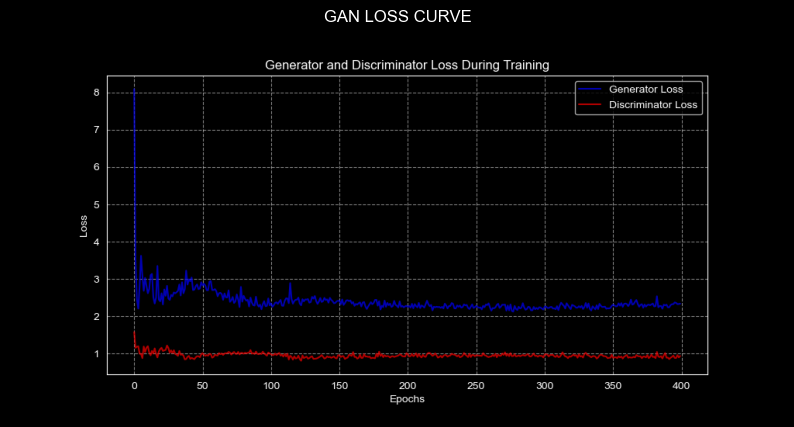

In [36]:
%matplotlib inline
img = mpimg.imread("C:/Users/azeem/PycharmProjects/ImageProcessingSemesterProject/Results/GAN_Results/GAN_Loss_Curve.png")

plt.figure(figsize=(10, 6))
plt.imshow(img)

plt.axis('off')
plt.title(f"GAN LOSS CURVE")
plt.show()

In [32]:
NUM_IMAGES_TO_GENERATE = 1000
OUTPUT_FOLDER = "GAN_Generated_Images"
MODEL_PATH = "Results/GAN_Results/perfect_generator.pth"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

Z_DIM = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Loading model from {MODEL_PATH}...")
netG = Generator().to(DEVICE)

try:
    # map_location ensures it loads on CPU if CUDA is not available
    netG.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading weights: {e}")
    print("Double check that the Generator class structure matches exactly what you trained.")
    exit()

netG.eval()

print(f"Generating {NUM_IMAGES_TO_GENERATE} images...")

with torch.no_grad():
    for i in range(NUM_IMAGES_TO_GENERATE):
        noise = torch.randn(1, Z_DIM, 1, 1, device=DEVICE)
        fake = netG(noise).detach().cpu()

        vutils.save_image(fake, f"{OUTPUT_FOLDER}/gen_{i}.png", normalize=True)

print(f"✅ Done! {NUM_IMAGES_TO_GENERATE} images saved to '{OUTPUT_FOLDER}'")

Loading model from Results/GAN_Results/perfect_generator.pth...
✅ Model loaded successfully!
Generating 1000 images...


C:\Users\azeem\AppData\Local\Temp\ipykernel_42156\3665602662.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(MODEL_PATH, map_location=DE

✅ Done! 1000 images saved to 'GAN_Generated_Images'


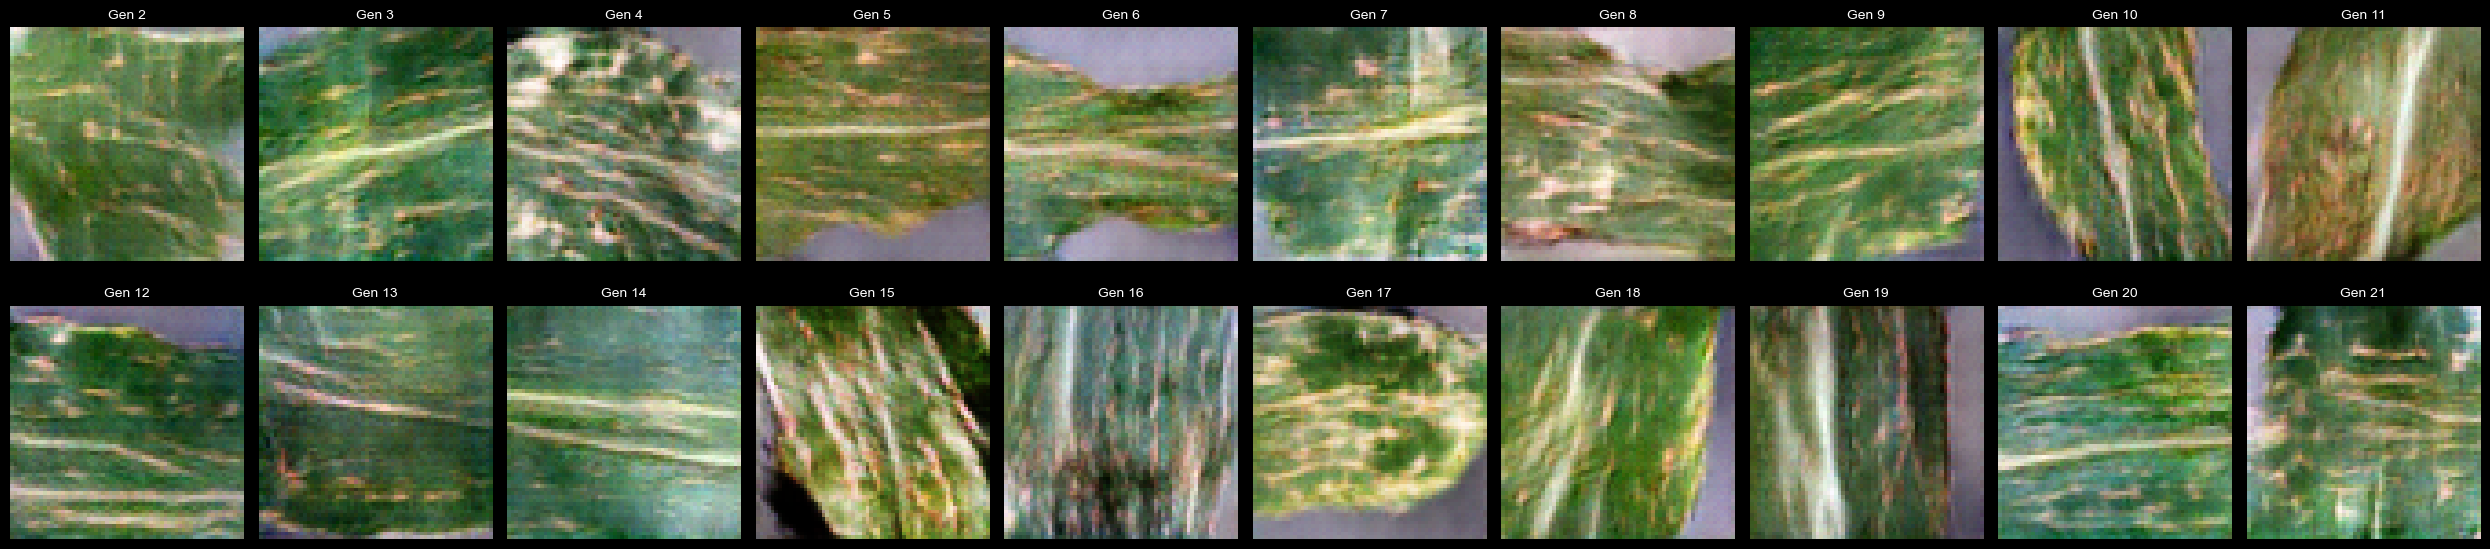

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

base_path = "C:/Users/azeem/PycharmProjects/ImageProcessingSemesterProject/GAN_Generated_Images/Minority/"

plt.figure(figsize=(25, 6))

for i in range(2, 22):
    img_name = f"gen_{i}.png"
    img_path = os.path.join(base_path, img_name)

    if os.path.exists(img_path):
        img = mpimg.imread(img_path)

        plt.subplot(2, 10, i-1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Gen {i}", fontsize=10)
    else:
        continue

plt.tight_layout()

plt.savefig(os.path.join(base_path, "20_image_comparison.png"), dpi=300)
plt.show()